In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# old = '/Users/tianjunma/Projects/audio_source_separation/multimodal_listener/data/b2_spectrograms/'
new = '/home/tianjunm/Documents/Projects/dataset/a1_spectrograms/'
d = ds.SignalDataset(root_dir=new)

In [27]:
dataloader = torch.utils.data.DataLoader(d, batch_size=32, shuffle=False)

In [28]:
for i, info in enumerate(dataloader):
    aggregate = info['aggregate']
    ground_truths = [gt for gt in info['ground_truths']]
    

# print(d[27*32])
# for i, info in enumerate(dataloader):
#     print(i)
#     if i==26:
#         print(info)

In [29]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    mel_spect = librosa.feature.melspectrogram(S=spect)
    db_data = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)

torch.Size([7, 691, 258])
(2286.7139+1378.2294j)


/home/tianjunm/anaconda3/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/tianjunm/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:888: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  warnings.warn('power_to_db was called on complex input so phase '


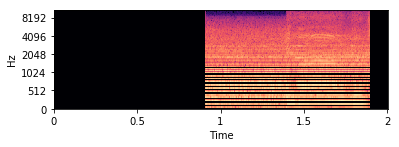

In [58]:
import numpy as np

# aggregate = np.load('/home/tianjunm/Documents/Projects/dataset/b1_spectrograms/10000/gt/0.npy')
print(aggregate.shape)
agg = aggregate[0].numpy().T
r = np.split(agg, 2)[0]
i = np.split(agg, 2)[1]

c = r + 1j * i

# c = aggregate[0] + 1j * aggregate[1]

print(np.max(c))
plt.subplot(2, 1, 1)

display(c, 22050*8)

In [32]:
import numpy as np
# agg = np.load('/home/tianjunm/Documents/Projects/dataset/a1_spectrograms/1000/gt/4.npy')

# def concat(m):
#     num_features, nrows, ncols = m.shape
#     result = np.zeros((nrows*num_features, ncols))

#     for i in range(num_features):
#         start = i * nrows;
#         end = (i + 1) * nrows;
#         result[start:end, :] = m[i]
#     return result

# agg_concat = concat(agg)
# aggregate = torch.t(torch.from_numpy(agg_concat))

# # dataloader
# aggregate = aggregate.unsqueeze(0).float()
print(aggregate.size())
bs, seq_len, input_dim = aggregate.size()

net = model.models.Baseline(input_dim, seq_len=seq_len, num_sources=2)

net2 = model.models.A1(input_dim, seq_len=seq_len, num_sources=2)

net2.load_state_dict(torch.load('pretrained/A1model_checkpoint_1716.pth'))
net2.eval()

torch.Size([7, 691, 258])


A1(
  (lstm): LSTM(258, 100)
  (fc): Linear(in_features=100, out_features=516, bias=True)
)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
print(device)

cuda:0


In [67]:
preds = net(aggregate)

In [48]:
preds[0].size()

torch.Size([691, 7, 258])

In [33]:
preds2 = net2(aggregate)

In [47]:
preds2[0].size()

torch.Size([691, 7, 258])

/home/tianjunm/anaconda3/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/tianjunm/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:888: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  warnings.warn('power_to_db was called on complex input so phase '


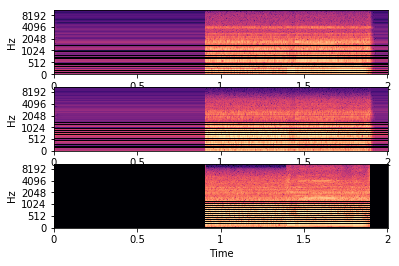

In [59]:
a = aggregate[0]
g1 = preds2[0][:, 0, :].detach().numpy().T
g2 = preds2[1][:, 0, :].detach().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

plt.subplot(3, 1, 1)
display(c1, 22050*8)
plt.subplot(3, 1, 2)
display(c2, 22050*8)
plt.subplot(3, 1, 3)
display(c, 22050*8)

In [61]:
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt

aggregate

In [67]:
_, data = scipy.signal.istft(c, fs=22050, nfft = 256)
IPython.display.Audio(data=data, rate=22050)

predicted separations

In [65]:
_, rdata = scipy.signal.istft(c1, fs=22050, nfft = 256)
IPython.display.Audio(data=rdata, rate=22050)

In [66]:
_, rdata = scipy.signal.istft(c2, fs=22050, nfft = 256)
IPython.display.Audio(data=rdata, rate=22050)

In [38]:
criterion = model.models.MinLoss(device, metric='correlation')

In [39]:
loss = criterion(preds, ground_truths)
loss

NameError: name 'preds' is not defined

In [40]:
loss2 = criterion(preds2, ground_truths)
loss2

tensor(285516.1250, device='cuda:0', grad_fn=<SumBackward0>)

In [62]:
loss.backward()

In [63]:
loss2.backward()

In [64]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer.step()
# preds2 = net(aggregate)

In [69]:
opt2= optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)
opt2.step()

tensor(461107.5000, grad_fn=<SumBackward0>)

In [16]:
print(len(ground_truths))
print(ground_truths[0].size())
gt = net.reshape(ground_truths[0])
print(torch.squeeze(gt[:, 0, :], dim=1).size())

2
torch.Size([32, 173, 1025])
torch.Size([173, 1025])


In [6]:
# print(aggregate[:, 0])
# agg = torch.t(aggregate)
# print(agg[0, :])
print(aggregate.size())
print(aggregate[1, 1, :])
seq_len = aggregate.size()[1]
aggs = [aggregate[:, t, :] for t in range(seq_len)]
x = torch.cat(aggs).view(173, bs, -1)
print(x[1, 1, :])
print(x.size())

torch.Size([32, 173, 1025])
tensor([1.4197e-19, 9.8981e-19, 1.4690e-17,  ..., 8.6916e-19, 1.9786e-18,
        1.6256e-18])
tensor([1.4197e-19, 9.8981e-19, 1.4690e-17,  ..., 8.6916e-19, 1.9786e-18,
        1.6256e-18])
torch.Size([173, 32, 1025])


In [81]:
# from scipy.spatial import distance
a = np.arange(15).reshape(3,5)
b = np.random.randint(5, size=(3, 5))
# print(a)
# print(b)
# a.reshape(1, 5) - b.reshape(5, 1)

# distance.cdist(a, b)

# a.flatten()


t = torch.arange(24).view(2, 3, -1)

print(t)
print(t[:, 0, :])
print(t[:, 0, :].numpy().flatten())

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])
tensor([[ 0,  1,  2,  3],
        [12, 13, 14, 15]])
[ 0  1  2  3 12 13 14 15]


In [31]:


# m = np.zeros((2, 3, 4))
# m[0] = np.arange(12).reshape(3,4)
# m[1] = np.arange(12).reshape(3,4) * 2

# m_c = concat(m)

def check(m_c, m):
    for i in range(m_c.shape[0]):
        for j in range(m_c.shape[1]):
            batch = i // m.shape[1]
            ii = i % m.shape[1]
            assert(m_c[i][j] == m[batch][ii][j])
    print("passed")

check(agg_concat, agg)

passed
